In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from env.bertrand_env import BertrandPricingEnv

In [2]:
class QLearningAgent:
    """
    Q-learning agent supporting three update protocols:
      - 'async': update only the played price
      - 'sync_perfect': update all prices using exact counterfactual profits
      - 'sync_downward': update others under downward-demand assumption
    """
    def __init__(self,
                 n_actions: int,
                 alpha: float = 0.1,
                 init_low: float = 10.0,
                 init_high: float = 20.0,
                 update_type: str = 'async',
                 cost: float = 2.0,
                 prices: np.ndarray = None):
        '''
        Parameters
        ----------
        n_actions: int
            Number of actions (prices) available to the agent.
        alpha: float
            Learning rate for Q-learning.
        init_low: float
            Lower bound for initial Q-values.
        init_high: float
            Upper bound for initial Q-values.
        update_type: str
            Update protocol used by the agent.
            - 'async': update only the played price
            - 'sync_perfect': update all prices using exact counterfactual profits
            - 'sync_downward': update others under downward-demand assumption
        cost: float
            Cost of the product.
        prices: np.ndarray
            Array of prices available to the agent.
        '''

        self.n_actions = n_actions
        self.Q = np.random.uniform(init_low, init_high, size=n_actions) # shape (n_actions,)
        self.alpha = alpha
        self.update_type = update_type
        self.cost = cost
        self.prices = prices

    def select_action(self) -> int:
        return int(np.argmax(self.Q))

    def update(self,
               action: int,
               reward: float,
               competitor_action: int):
        p_j = self.prices[competitor_action]
        p_i = self.prices[action]

        # realized demand at chosen price
        if p_i < p_j and p_i <= self.prices[-1]:
            q = 1.0
        elif p_i == p_j and p_i <= self.prices[-1]:
            q = 0.5
        else:
            q = 0.0

        base_profit = (p_i - self.cost) * q

        if self.update_type == 'async':
            # only update the chosen price
            self.Q[action] = self.alpha * reward + (1 - self.alpha) * self.Q[action]

        elif self.update_type == 'sync_perfect':
            # recompute for every price
            for i, p in enumerate(self.prices):
                if p < p_j and p <= self.prices[-1]:
                    d = 1.0
                elif p == p_j and p <= self.prices[-1]:
                    d = 0.5
                else:
                    d = 0.0
                profit = (p - self.cost) * d
                self.Q[i] = self.alpha * profit + (1 - self.alpha) * self.Q[i]

        elif self.update_type == 'sync_downward':
            # compute realized demand once
            q = 1.0 if (p_i < p_j and p_i <= self.prices[-1]) \
                else (0.5 if (p_i == p_j and p_i <= self.prices[-1]) else 0.0)

            for i, p in enumerate(self.prices):
                if i == action:
                    # chosen price gets actual profit
                    self.Q[i] = self.alpha * reward + (1 - self.alpha) * self.Q[i]
                else:
                    # downward‐demand estimate for any other price
                    profit_est = (p - self.cost) * q
                    # if p > chosen and current Q is too high, or
                    #    p < chosen and profit_est would improve it
                    if (p > p_i and self.Q[i] > profit_est) or \
                       (p < p_i and profit_est > self.Q[i]):
                        self.Q[i] = self.alpha * profit_est + (1 - self.alpha) * self.Q[i]
        else:
            raise ValueError(f"Unknown update_type: {self.update_type}")

In [3]:
def simulate_once(env, update_type, periods, alpha):
    """Run one simulation, return firm‑1 price history."""
    ag1 = QLearningAgent(len(env.prices), alpha, 10, 20, update_type, env.cost, env.prices)
    ag2 = QLearningAgent(len(env.prices), alpha, 10, 20, update_type, env.cost, env.prices)
    history = np.zeros(periods)

    for t in range(periods):
        a1 = ag1.select_action()
        a2 = ag2.select_action()
        _, (r1, r2), _, _ = env.step((a1, a2))
        ag1.update(a1, r1, a2)
        ag2.update(a2, r2, a1)
        history[t] = env.prices[a1]

    return history

def simulate_batch(update_type, periods, runs, alpha, env):
    """Run `runs` simulations in batch."""
    return np.array([simulate_once(env, update_type, periods, alpha)
                     for _ in range(runs)]) # shape (runs, periods). Stores firm-1 price history for each run.

def plot_percentiles(percentiles, periods, title):
    """
    Plot min, 25th, median, 75th, and max percentile lines.
    percentiles shape = (5, periods).
    """
    x = np.arange(periods)
    labels_linestyle = [
        ('Min',           '-'),
        ('25th percentile','--'),
        ('Median',        '-'),
        ('75th percentile','--'),
        ('Max',           '-'),
    ]
    plt.figure(figsize=(10, 4))
    for idx, (label, ls) in enumerate(labels_linestyle):
        lw = 2 if label == 'Median' else 1
        plt.plot(x, percentiles[idx], linestyle=ls, linewidth=lw, label=label)
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



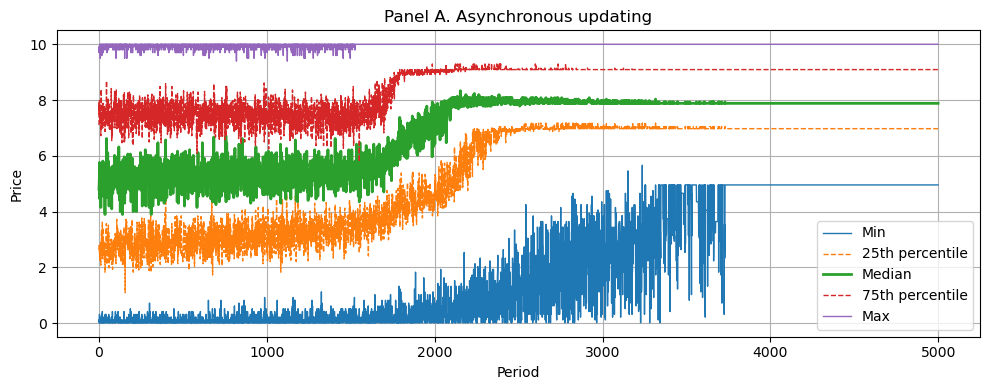

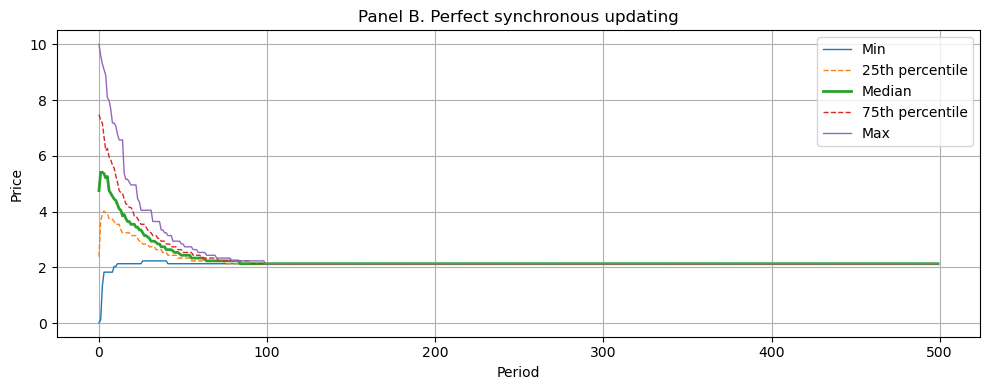

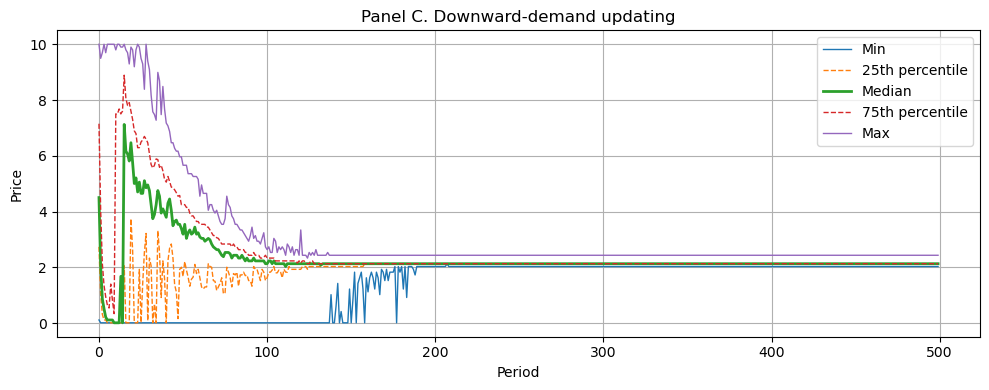

In [6]:
# Run the simulation and plot results
np.random.seed(0)
env = BertrandPricingEnv(price_min=0.01, price_max=10.0, grid_size=100, marginal_cost=2.0)

protocols = {
    "Panel A. Asynchronous updating":       ("async",         5000),
    "Panel B. Perfect synchronous updating":("sync_perfect",   500),
    "Panel C. Downward-demand updating":    ("sync_downward",  500),
}

runs = 100
alpha = 0.1

for title, (ptype, T) in protocols.items():
    batch = simulate_batch(ptype, T, runs, alpha, env)
    pc = np.percentile(batch, [0, 25, 50, 75, 100], axis=0)
    plot_percentiles(pc, T, title)